In [10]:
# pnadas to read data frames
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# for NLP
import re #regular expressions
import nltk 
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
import string

# for train test split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Supervised learning algorithms  
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For algorithm evalution
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mehbo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
# read data file
movie_df = pd.read_csv('IMDBDataset.csv')

In [12]:
# remove duplicates
movie_df['dup'] = movie_df.duplicated(subset=None, keep='first')
del movie_df['dup']

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Initialize stopwords and lemmatizer
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess(text):
    
    text = text.lower() # Convert to lowercase
    
    # Replace everything except a-z, A-Z, ".", "?", "!", "," with space
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove HTML tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)

    # Remove punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')

    # Remove stopwords
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    # Lemmatize the words and remove those in the custom stopwords list (if any)
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text) # Joining back into a string

    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # Remove emojis
    
    return text


In [14]:
# Apply preprocessing to review column
movie_df['prep'] = movie_df['review'].apply(lambda x: preprocess(x)) 
del movie_df['review'] # remove review column


In [15]:
# Tokenize the preprocessed text
movie_df['tokens'] = movie_df['prep'].apply(lambda x: re.findall(r"[\w']+", x))

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_df['prep'].values, movie_df['sentiment'].values, test_size=0.2, random_state=42, stratify=movie_df['sentiment'].values)

# Define the CountVectorizer (BoW approach)
count_vectorizer = CountVectorizer()

# Transform the training and testing data using CountVectorizer
bow_train_vectors = count_vectorizer.fit_transform(X_train)
bow_test_vectors = count_vectorizer.transform(X_test)

# Train the Logistic Regression classifier using the BoW features
classifier_bow = LogisticRegression()
classifier_bow.fit(bow_train_vectors, y_train)

# Predict using the BoW model
y_pred_bow = classifier_bow.predict(bow_test_vectors)

# Evaluate the BoW model
print(classification_report(y_test, y_pred_bow))
print("Accuracy score with BoW:", accuracy_score(y_test, y_pred_bow))


              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy score with BoW: 0.8877


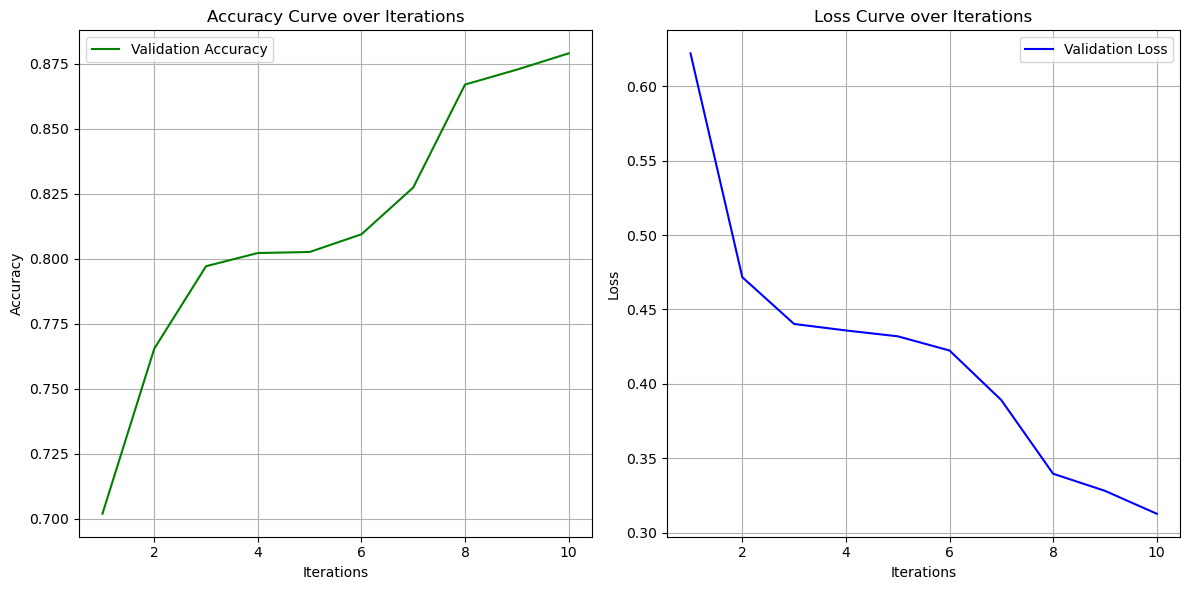

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Split your data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(movie_df['prep'].values,
                                                    movie_df['sentiment'].values,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=movie_df['sentiment'].values)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data
tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_val_vectors = tfidf_vectorizer.transform(X_val)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

# Initialize lists to track accuracy and loss
accuracy_values = []
loss_values = []

# Define the number of iterations
iterations = 10

for i in range(1, iterations + 1):
    # Train the model
    classifier = LogisticRegression(max_iter=i)
    classifier.fit(tfidf_train_vectors, y_train)

    # Predict on validation set
    y_val_pred = classifier.predict(tfidf_val_vectors)
    y_val_pred_prob = classifier.predict_proba(tfidf_val_vectors)

    # Calculate accuracy and loss
    accuracy = accuracy_score(y_val, y_val_pred)
    loss = log_loss(y_val, y_val_pred_prob)

    # Append to lists
    accuracy_values.append(accuracy)
    loss_values.append(loss)

# Plotting both the Accuracy and Loss Curves in one plot
plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(range(1, iterations + 1), accuracy_values, label='Validation Accuracy', color='green')
plt.title('Accuracy Curve over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(range(1, iterations + 1), loss_values, label='Validation Loss', color='blue')
plt.title('Loss Curve over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()